<a href="https://colab.research.google.com/github/sayanbanerjee32/TSAI_ERAv2_S7/blob/main/step2/S7_step2_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Add Regularization - Dropout
- Start transition block at receptive field 5
- Increase model capacity. Add more layers at the end.

## Results:

- Parameters: 7432
- Best Training Accuracy: 98.83%
- Best Test Accuracy: 99.07%

## Analysis:

- Model does not show any overfitting, however able to reach 99% accuracy consistently
- Test loss is flactuating towards end epochs. Thus use of LR scheduler might be helpful
- Error analysis suggests that there are combinations where model is confused more than others. e.g. target 9-predicted 4, target 2-predicted 7, target 8-predicted 6 are the top 3 cases with respect to number of error, however, target 6-predicted 4, target 9-predicted 7, target 3-predicted 7 are the top 3 cases with respect to median losses. Adding image augmentation for training set might be hlpful in pushing Test accuracy further.

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

#import from local modules
from model_2 import Net
from utils_2 import train, test, get_device, plot_accuracy_losses, plot_top_loss

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Train and Test transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [4]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 113728143.76it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43340140.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 175561429.61it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 19969107.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 1, 28, 28])
torch.Size([128])


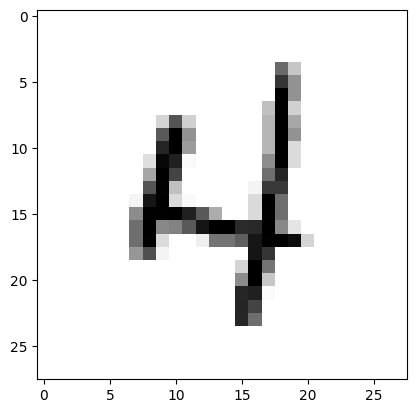

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

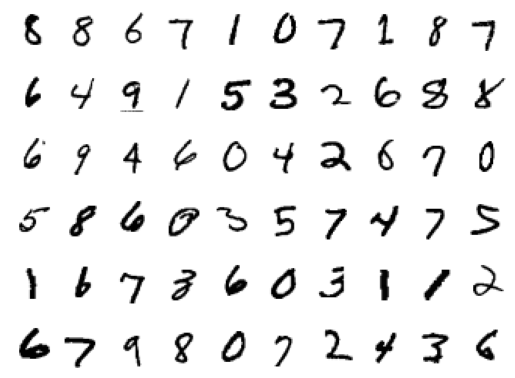

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Training

In [8]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)




Epoch 1


Train: Loss=0.1472 Batch_id=468 Accuracy=83.10: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]


Test set: Average loss: 0.1955, Accuracy: 9467/10000 (94.67%)

Epoch 2


Train: Loss=0.1075 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]


Test set: Average loss: 0.0758, Accuracy: 9787/10000 (97.87%)

Epoch 3


Train: Loss=0.0523 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]


Test set: Average loss: 0.0542, Accuracy: 9840/10000 (98.40%)

Epoch 4


Train: Loss=0.0222 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]


Test set: Average loss: 0.0466, Accuracy: 9864/10000 (98.64%)

Epoch 5


Train: Loss=0.0362 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Test set: Average loss: 0.0521, Accuracy: 9844/10000 (98.44%)

Epoch 6


Train: Loss=0.0914 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]


Test set: Average loss: 0.0465, Accuracy: 9860/10000 (98.60%)

Epoch 7


Train: Loss=0.0562 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]


Test set: Average loss: 0.0371, Accuracy: 9887/10000 (98.87%)

Epoch 8


Train: Loss=0.0427 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]


Test set: Average loss: 0.0431, Accuracy: 9869/10000 (98.69%)

Epoch 9


Train: Loss=0.0432 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]


Test set: Average loss: 0.0327, Accuracy: 9896/10000 (98.96%)

Epoch 10


Train: Loss=0.0137 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]


Test set: Average loss: 0.0376, Accuracy: 9873/10000 (98.73%)

Epoch 11


Train: Loss=0.0196 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]


Test set: Average loss: 0.0308, Accuracy: 9907/10000 (99.07%)

Epoch 12


Train: Loss=0.1340 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]


Test set: Average loss: 0.0306, Accuracy: 9902/10000 (99.02%)

Epoch 13


Train: Loss=0.0616 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]


Test set: Average loss: 0.0302, Accuracy: 9900/10000 (99.00%)

Epoch 14


Train: Loss=0.0308 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]


Test set: Average loss: 0.0319, Accuracy: 9895/10000 (98.95%)

Epoch 15


Train: Loss=0.0722 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


Test set: Average loss: 0.0321, Accuracy: 9899/10000 (98.99%)



## Visualise training and test losses and accuracies

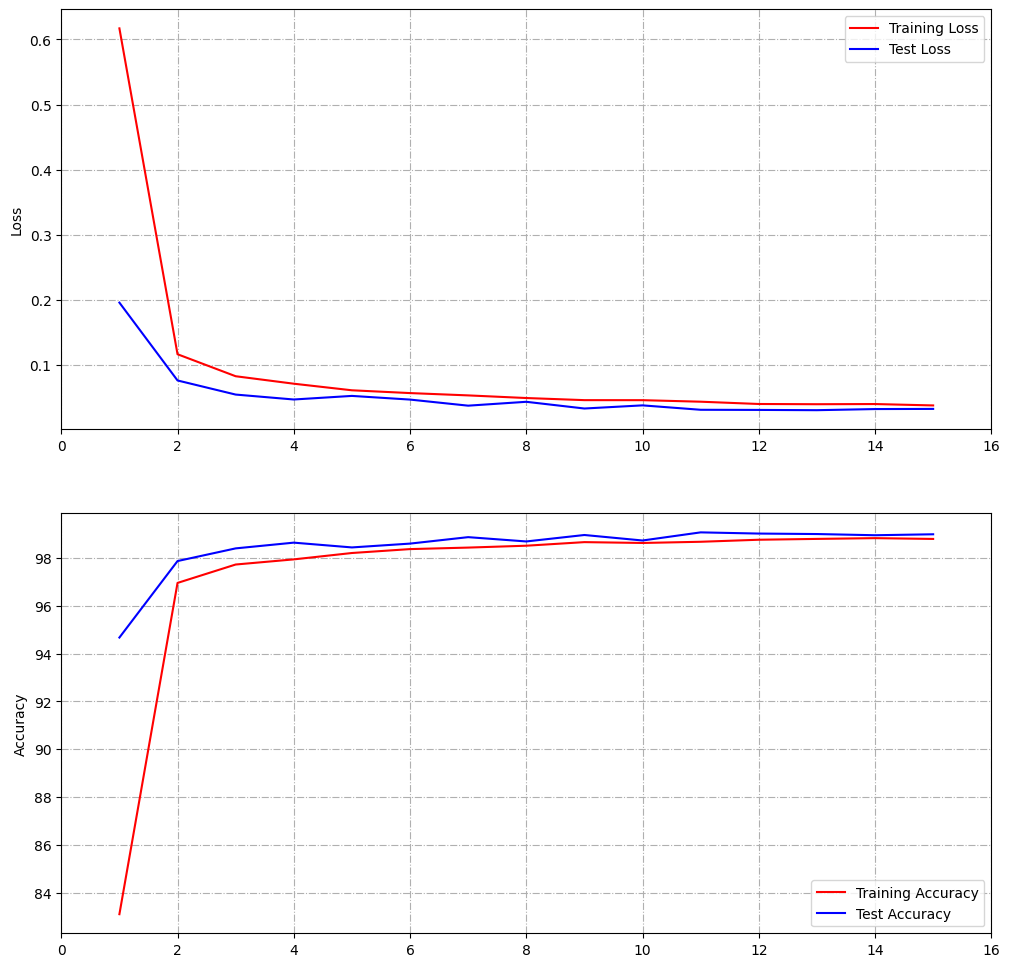

In [11]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


total wrong predictions: 101
target: 7, num_img: 5


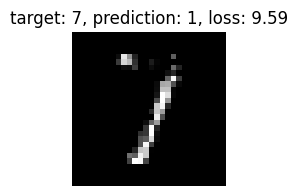

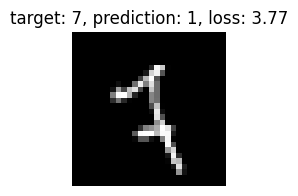

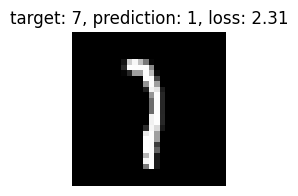

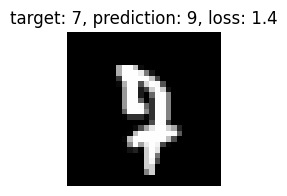

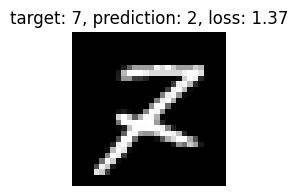

target: 6, num_img: 5


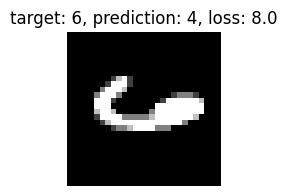

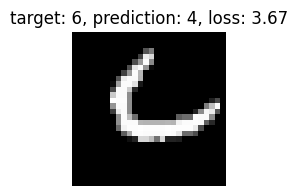

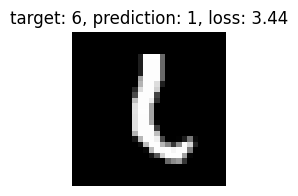

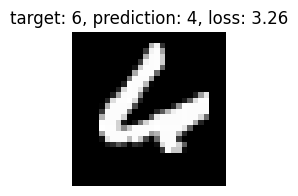

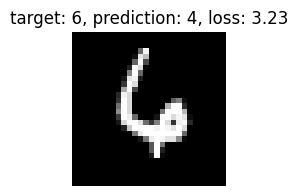

target: 8, num_img: 5


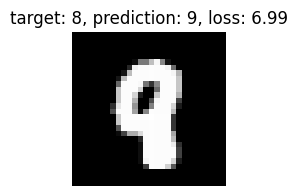

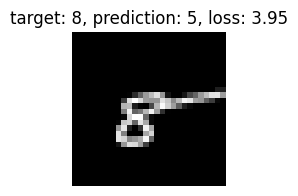

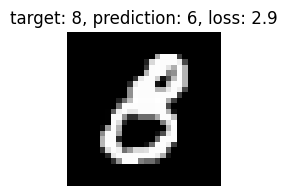

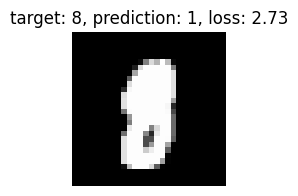

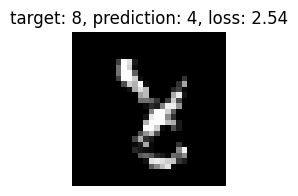

target: 9, num_img: 5


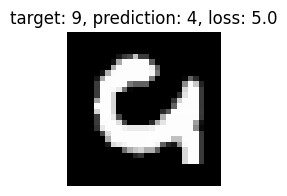

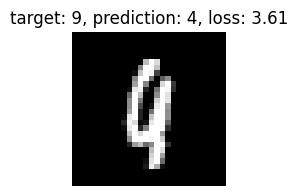

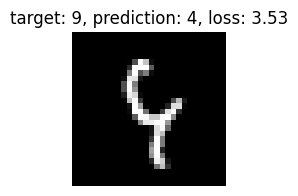

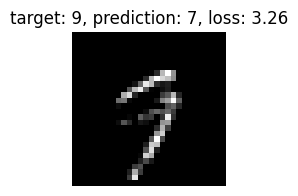

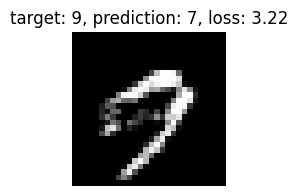

target: 5, num_img: 5


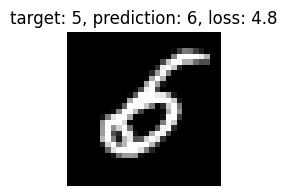

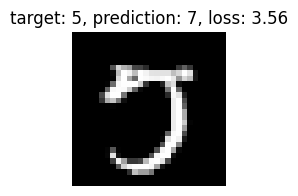

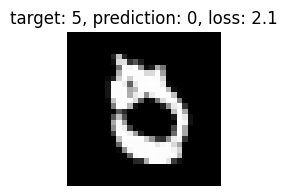

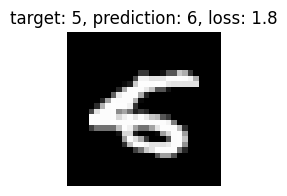

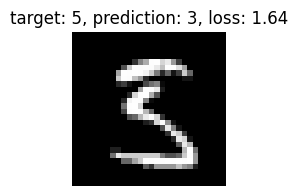

target: 3, num_img: 5


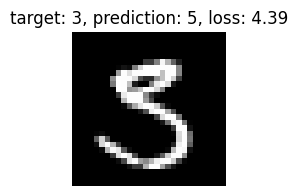

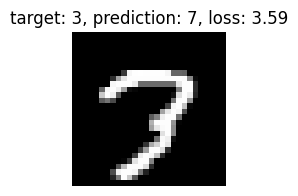

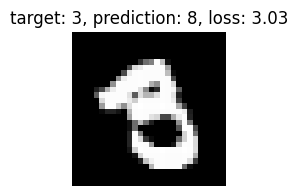

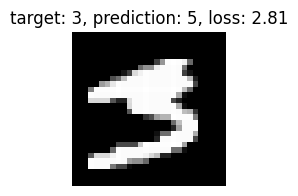

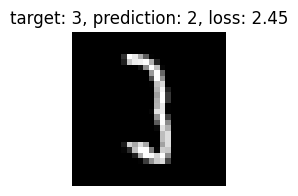

target: 2, num_img: 5


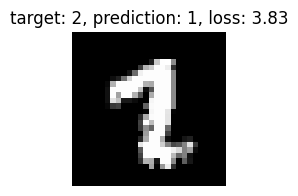

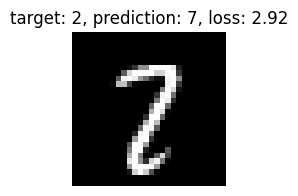

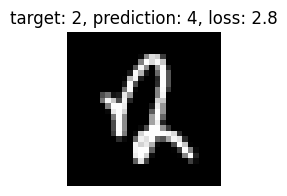

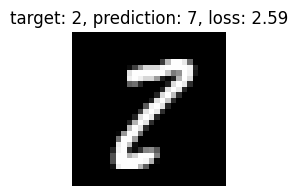

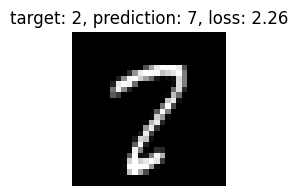

target: 0, num_img: 5


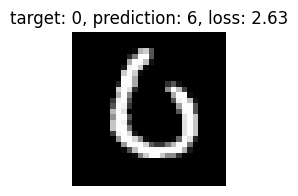

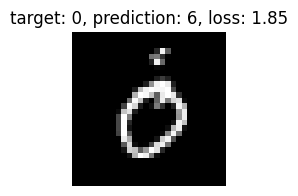

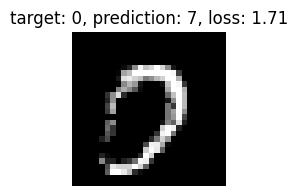

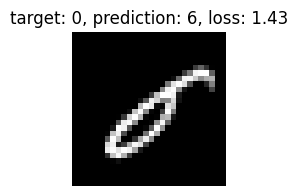

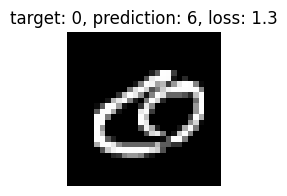

target: 1, num_img: 3


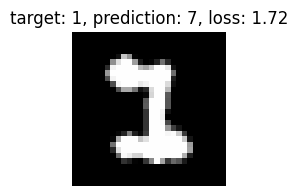

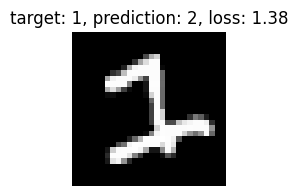

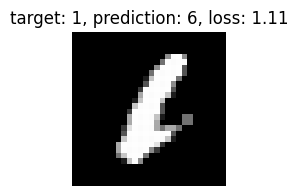

In [35]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion, max_item = 5)

In [25]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
34,9,4,1.948683,10
8,2,7,1.380502,10
30,8,6,1.577843,10
11,3,5,1.615171,6
21,6,4,3.246903,6
0,0,6,1.433977,5
22,7,1,2.306299,5
19,6,0,1.628707,4
24,7,9,1.219638,3
17,5,6,1.802780,3


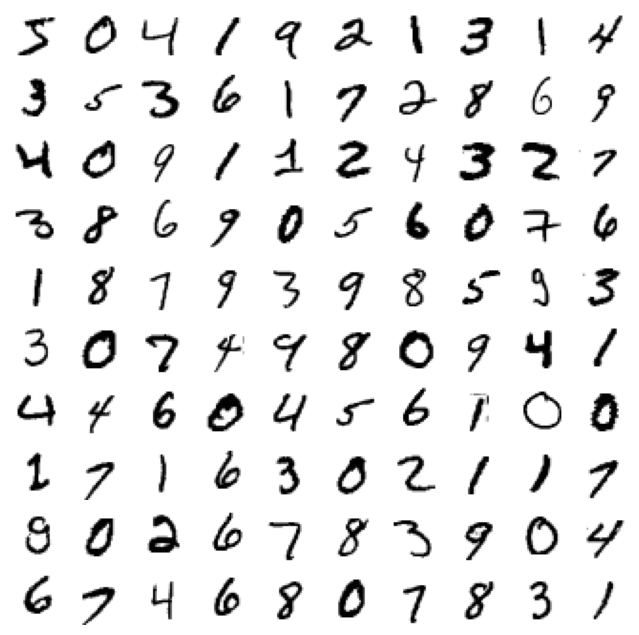

In [26]:
# prompt: print mnist image as small thumb nails

import matplotlib.pyplot as plt

# Load the MNIST dataset
mnist = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

# Get a sample of 100 images
images = mnist.data[:100]

# Create a figure with 10 rows and 10 columns
fig, axs = plt.subplots(10, 10, figsize=(8, 8))

# Iterate over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray_r')
    ax.axis('off')

# Show the plot
plt.show()
